In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import Dataset, DataLoader

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Data Generating Process 
Consider a simple case as follows: 

$y = a+ b x + e$,

where $y\in \mathbb{R}$, and $x \in \mathbb{R}$. Consider we observe $\{x_i,y_i\}_{i=1}^N$, and we want run the following regression

$y_i  = \hat{a}+\hat{b} x_i$. We do this in two different method of opimization, 

(1) Gradient Descent

(2) Stochastic Gradient Descent



In [4]:
class Data_gen():
    def __init__(self, 
                 a =1.0,
                b = 1.0,
                N = 32,
                sigma = 0.1):
        torch.manual_seed(0)
        self.a= a
        self.b = b
        self.N = N
        self.sigma = sigma
        self.e = self.sigma*torch.randn(N)
        self.x = torch.arange(0.0,self.N,1)/self.N
        self.y = self.a+ self.b*self.x+self.e
    def train_data(self):
        data = torch.stack((self.x,self.y),1)
        return data


In [5]:
x = Data_gen().train_data()[:,[0]]
y = Data_gen().train_data()[:,[1]] 


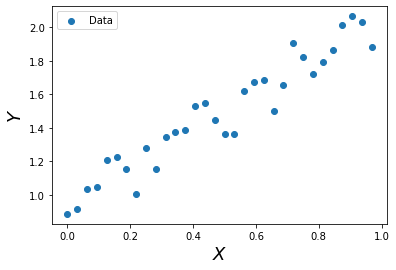

In [6]:
plt.scatter(x,y, zorder=1,label= r"Data")
plt.ylabel(r"$Y$",fontsize=18)
plt.xlabel(r"$X$",fontsize=18)
plt.legend(loc='best')
plt.show()

Finding the OLS estimators:

$\hat{b} = \frac{\hat{cov}(x,y)}{\hat{var}(x)}$

$\hat{a} = \hat{\mathbb{E}}[y]- \hat{b}~\hat{\mathbb{E}}(x)$

In [7]:
dx = x-x.mean()
dy = y-y.mean()
cov = torch.matmul(dx.t(),dy)
var_x = torch.matmul(dx.t(),dx)

In [8]:
b_hat_ols = cov/var_x
a_hat_ols = y.mean() - b_hat_ols* x.mean()
print('b_hat=',b_hat_ols.item())
print('a_hat=',a_hat_ols.item())

b_hat= 1.107523798942566
a_hat= 0.9485774040222168


# Designing the neural Net

In [9]:
class NN(nn.Module):
    # This accepts an input of the form torch.Size([M, N])
    # M = sample size
    # N = number of firms (features)
    # output =  torch.Size([M, 1])
    def __init__(self,
                hidden_bias = True):
        super().__init__()
        self.hidden_bias = hidden_bias
        
        self.fc1 = nn.Linear(1,1, bias = self.hidden_bias)
        #hardcoding the initial weights
        self.fc1.weight.data = torch.tensor([[-1.5]])
        self.fc1.bias.data = torch.tensor([[3.0]])
    
    def forward(self, x):
        p_output = self.fc1(x)
        return  p_output 

# Designing the dataloader

In [10]:
class Dataset_loader(Dataset):
    def __init__(self):
        self.train_data = Data_gen().train_data()
        self.x = self.train_data[:,[0]]
        self.y = self.train_data[:,1:]
        self.n_samples = self.train_data.shape[0]
    
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
      

In [11]:
dataset = Dataset_loader()
dataloader_GD = DataLoader(dataset = dataset, batch_size = Data_gen().N , shuffle = False)
dataloader_SGD = DataLoader(dataset = dataset, batch_size = 1 , shuffle = True)

# Training Loop GD

In [12]:
model = NN()

learning_rate = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)

num_epochs = 100

In [13]:
weight_GD = []
bias_GD = []

In [14]:

for epoch in range(num_epochs):
    for i, (x,y) in enumerate(dataloader_GD):
        weight_GD.append(model.state_dict()['fc1.weight'].item())
        bias_GD.append(model.state_dict()['fc1.bias'].item())
        res = y - model(x)
        loss = res.pow(2).mean()
        optimizer.zero_grad() #this is essentially  with torch.no_grad():

        loss.backward()
        optimizer.step()
                
    #if epoch % 100 == 0:
    #    print(epoch,',',"{:.2e}".format(loss.detach().numpy()))       
        
        

In [15]:
bias_GD = np.array(bias_GD)
weight_GD = np.array(weight_GD)

# Training Loop SGD

In [16]:
model = NN()

learning_rate = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)

num_epochs = 10

In [17]:
weight_SGD = []
bias_SGD = []

In [18]:
for epoch in range(num_epochs):
    for i, (x,y) in enumerate(dataloader_SGD):
        weight_SGD.append(model.state_dict()['fc1.weight'].item())
        bias_SGD.append(model.state_dict()['fc1.bias'].item())
        res = y - model(x)
        loss = res.pow(2).mean()
        optimizer.zero_grad() #this is essentially  with torch.no_grad():

        loss.backward()
        optimizer.step()
                

In [19]:
bias_SGD = np.array(bias_SGD)
weight_SGD = np.array(weight_SGD)
bias_SGD;

# Plotting

The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


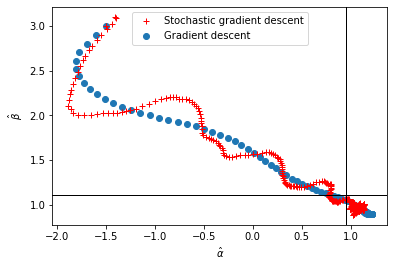

In [20]:
plt.plot(weight_SGD,bias_SGD,'r+',label= r"Stochastic gradient descent")
plt.scatter(weight_GD,bias_GD, zorder=1,label= r"Gradient descent")
plt.ylabel(r"$\hat{\beta}$")
plt.xlabel(r"$\hat{\alpha}$")
plt.axhline(b_hat_ols,linewidth=1, color='k' )
plt.axvline(a_hat_ols,linewidth=1, color='k')
plt.legend(loc='best')
plt.show()

# Plotting a_hat

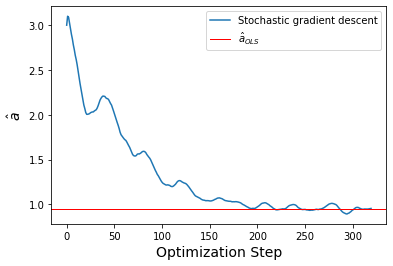

In [21]:
plt.plot(bias_SGD,label= r"Stochastic gradient descent")
plt.axhline(a_hat_ols.item(),linewidth=1, color='r', label = r"$\hat{a}_{OLS}$" )
plt.xlabel(r"Optimization Step", fontsize = 14)
plt.ylabel(r"$\hat{a}$", fontsize = 14)
plt.legend(loc='best')
plt.show()


# Plotting b_hat

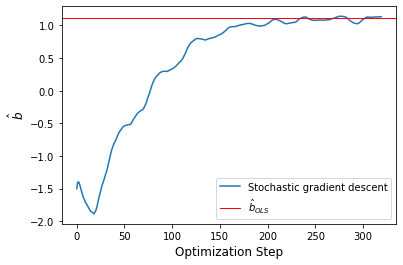

In [22]:
plt.plot(weight_SGD,label= r"Stochastic gradient descent")
plt.axhline(b_hat_ols.item(),linewidth=1, color='r', label = r"$\hat{b}_{OLS}$")
plt.ylabel(r"$\hat{b}$", fontsize = 12)
plt.xlabel(r"Optimization Step", fontsize = 12)
plt.legend(loc='lower right')
plt.show()

# Plotting the gif 

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [24]:
filenames = []
for i in range(len(weight_SGD)):
    # plot the line chart
    plt.plot(weight_SGD[:i],label= r"Stochastic gradient descent" )
    plt.axhline(b_hat_ols.item(),linewidth=1, color='r', label = r"$\hat{b}_{OLS}$")
    plt.ylabel(r"$\hat{b}$", fontsize = 12)
    plt.xlabel(r"Optimization Step", fontsize = 12)
    plt.legend(loc='lower right')
    plt.ylim(-2.0,1.2)
    plt.xlim(0,320)
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()# build gif
with imageio.get_writer('SGD_LOS_b.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [25]:
filenames = []
for i in range(len(bias_SGD)):
    # plot the line chart
    plt.plot(bias_SGD[:i],label= r"Stochastic gradient descent" )
    plt.axhline(a_hat_ols.item(),linewidth=1, color='r', label = r"$\hat{a}_{OLS}$")
    plt.ylabel(r"$\hat{a}$", fontsize = 12)
    plt.xlabel(r"Optimization Step", fontsize = 12)
    plt.legend(loc='lower right')
    plt.ylim(0.5,3.0)
    plt.xlim(0,320)
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()# build gif
with imageio.get_writer('SGD_LOS_a.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)